# Value at Risk: A simple way to monitor market risk with atoti

Financial institutions all have to find a balance between profit and risk. The more risk taken the higher the profit can be. However if we want to avoid collapses such as that of Lehman Brothers in 2008, risk has to be controlled.  

There are several kinds of risk:
- Shortfall of a counterparty, also known as credit risk: This is the risk that a borrower cannot repay its credit
- Market risk: This is the risk that certain assets could lose their value. For example one might invest in wine bottle in the hope that they gain value with age while they might not.

Market risk is widely monitored in finance. Institutions have large portfolios with a lot of assets, and forecasting the value of each asset is simply impossible as COVID-19 kindly reminded us recently. The key is then to assess what are the (statistical) chances that the value of certain assets remain in a certain envelope and what the potential losses are. This is where the value at risk – or VaR – comes into action.

There are different approaches to calculating the VaR. The one we will use in this notebook is based on the aggregation of simulated profit & losses, and then calculated using a percentile of the empirical distribution.

We will see how we can compute and aggregate pretty easily this non-linear indicator with atoti, and then perform simulations around it.

## Importing the necessary libraries

In [1]:
import atoti

## Data Loading
#### Initializing atoti

In [2]:
from atoti.config import create_config

# tell atoti to load the database containing the UI dashboards
config = create_config(metadata_db="./metadata.db")
session = atoti.create_session(config=config)

#### Loading the data

Instruments are financial products. In this notebook they are foreign exchange options.

In [3]:
# uncomment this line to install atoti-aws
# !conda install atoti-aws -y

In [4]:
instruments = session.read_csv(
    "s3://data.atoti.io/notebooks/var/instruments.csv",
    keys=["instrument_code"],
    store_name="Instruments",
)

In [5]:
instruments.head()

,underlying_code,strike,option_type,maturity,contract_size
instrument_code,,,,,
EURUSD=X c 1 @1.251000,EURUSD=X,1.251000,c,1,100000
EURUSD=X p 1 @1.251000,EURUSD=X,1.251000,p,1,100000
EURUSD=X c 1 @1.106200,EURUSD=X,1.106200,c,1,100000
EURUSD=X p 1 @1.106200,EURUSD=X,1.106200,p,1,100000
EURUSD=X c 1 @1.163233,EURUSD=X,1.163233,c,1,100000


The analytics store gives more information on each instrument, more notably:
- The PnL (profit and loss) of the previous day
- A vector of the PnLs of the instrument for the last 272 days. PnLs are typically calculated by complex price engines and such vectors would be their output.

In [6]:
analytics = session.read_csv(
    "s3://data.atoti.io/notebooks/var/simulated_pl_vol_depth_150.csv",
    keys=["instrument_code"],
    store_name="Instruments Analytics",
    array_sep=";",
)

In [7]:
analytics.head()

,pnl_vector,vector_size,pnl
instrument_code,,,
EURAUD=X c 1 @1.480500,"doubleVector[372]{-710.83, ...}",372.0,-710.83
EURAUD=X c 1 @1.578882,"doubleVector[372]{203.23, ...}",372.0,203.23
EURAUD=X c 1 @1.662000,"doubleVector[372]{3661.89, ...}",372.0,3661.89
EURAUD=X p 1 @1.480500,"doubleVector[372]{-1193.54, ...}",372.0,-1193.54
EURAUD=X p 1 @1.578882,"doubleVector[372]{-868.54, ...}",372.0,-868.54


In [8]:
# We will force the type of those two columns so that when using auto mode to create the cube, they will directly create sum and avg measures.
# Since Int columns create hierarchies in auto mode, another solution would have been to create the measures manually.
positions_store_types = {
    "quantity": atoti.type.DOUBLE,
    "purchase_price": atoti.type.DOUBLE,
}

Positions give us the quantities of each instrument we currently hold in our portfolio.  
They are grouped into books.

In [9]:
positions = session.read_csv(
    "s3://data.atoti.io/notebooks/var/eod_positions.csv",
    keys=["instrument_code", "book_id"],
    store_name="Positions",
    types=positions_store_types,
)

In [10]:
positions.head()

underlying  quantity  purchase_price
instrument_code        book_id                                     
EURUSD=X c 1 @1.251000 1         EURUSD=X       2.0             0.0
                       2         EURUSD=X      -8.0             0.0
                       3         EURUSD=X       2.0             0.0
                       4         EURUSD=X       1.0             0.0
                       5         EURUSD=X       0.0             0.0

### Data model and cube
We will first join the three previous stores altogether.

In [11]:
positions.join(instruments)
instruments.join(analytics)

To start our analysis, we create our cube using `Positions` as the base store.

In [12]:
cube = session.create_cube(positions, "Positions")

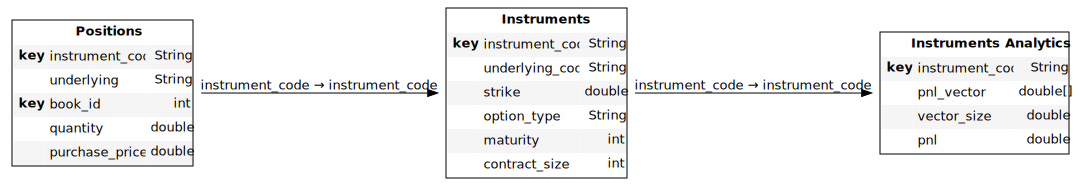

In [13]:
cube.schema

In auto mode, atoti creates hierarchies for each column that is not of type float, sum and average measures for each column of type float.  
This can of course be fine-tuned to either switch to full manual mode and create hierarchies/measures yourself, or simply edit what has been created automatically (adding a hierarchy for a numerical column for example). The available cube creation modes are detailed in the [documentation](https://docs.atoti.io).   

Below you can explore which measures/levels/hierarchies have been automatically created in our cube.

In [14]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels
cube

#### Computing the PnL of the previous day

In [15]:
m["pnl.VALUE"] = analytics["pnl"]
m["pnl_vector.VALUE"] = analytics["pnl_vector"]

A simple command lets you run atoti's UI directly in the notebook. This is pretty convenient to explore the data you just loaded or make sure the measures defined produce the correct results.

In [16]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Looking at the PnL in various ways
Compute the PnL for each instrument by multiplying the PnL value against the quantity against the `instrument_code` level.  
Above the scope level, the PnL will be aggregated.

In [17]:
m["PnL"] = atoti.agg.sum(
    m["quantity.SUM"] * m["pnl.VALUE"], scope=atoti.scope.origin(lvl["instrument_code"])
)

Run the following cells to see the atoti visualizations

In [18]:
session.visualize(name="PnL Pivot Table")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [19]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Collaboration tools
All the tables/charts created in the notebook can be published and made available in atoti's UI, a user friendly interface where anybody can create dashboards, share them, and drill down the data.

atoti's UI can be reached with a link using command `session.url`  
Run the cell below to have a look at a dashboard we have prepared using the above chart and pivot table.

In [20]:
session.url + "/#/dashboard/94c"

'http://localhost:58493/#/dashboard/94c'

### Customizing hierarchies

In large organizations, books usually belong to business units that are made up of smaller sub-business units and different trading desks.  
atoti lets you add new hierarchies on the fly without having to add columns into existing tables or re-launch time consuming batch computations.

In this example we will import a file containing level information on Business Units, Sub-Business Units, Trading Desks and Book. Since we already have book IDs linked to our instruments, we will simply use this new information to create an additional hierarchy with these levels under it.

In [21]:
trading_desks = session.read_csv(
    "s3://data.atoti.io/notebooks/var/trading_desk.csv",
    keys=["book_id"],
    store_name="Trading Desk",
)
positions.join(trading_desks)

h["Trading Book Hierarchy"] = {
    "Business Unit": lvl["business_unit"],
    "Sub Business Unit": lvl["sub_business_unit"],
    "Trading Desk": lvl["trading_desk"],
    "Book": lvl["book"],
}

The cube structure has been modified on the fly, we can now use the new hierarchy on any visualization. The data model becomes the following:

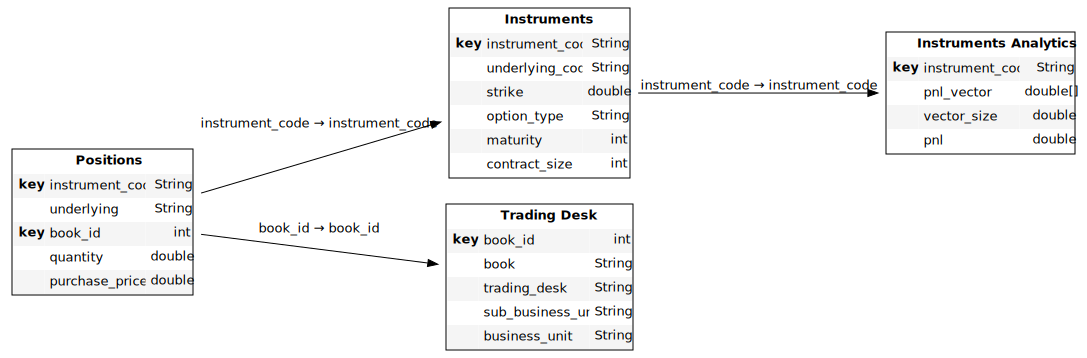

In [22]:
cube.schema

In [23]:
session.visualize("Business Hierarchy Pivot Table")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Value at Risk

We have vectors of the PnLs of every instrument for the last 372 days for each instrument. 
First thing we will do is define a "scaled vector" measure that will multiply those PnLs vectors by the quantities we hold in our positions at instrument level, aggregate it as a sum above.

In [24]:
scaled_pnl_vector = m["quantity.SUM"] * m["pnl_vector.VALUE"]
m["Position Vector"] = atoti.agg.sum(
    scaled_pnl_vector, scope=atoti.scope.origin(lvl["instrument_code"])
)

From [Wikipedia](https://en.wikipedia.org/wiki/Value_at_risk):    
Value at risk (VaR) \[...\] estimates how much a set of investments might lose (with a given probability), given normal market conditions, in a set time period such as a day.  
For a given portfolio, time horizon, and probability $\rho$, the $\rho$ VaR can be defined informally as the maximum possible loss during that time after we exclude all worse outcomes whose combined probability is at most $\rho$. 

In our notebook, we will rather use a confidence level that is $1 - \rho$, where $\rho$ is a 5% chance that we will make a loss greater than the maximum possible loss calculated.  
The maximum possible loss will be computed based on the past PnLs that we have per instrument in vectors.

In [25]:
m["Confidence Level"] = 0.95
m["VaR"] = atoti.array.quantile(m["Position Vector"], (1-m["Confidence Level"]))

In [26]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

The results above show that with a 95% confidence level, we are sure that the maximum loss would be -488k for Forex.

95% is an arbitrary value, what if the extreme cases are ten times worse than what we have? Or what if chosing a lower confidence level would tremendously decrease the VaR?

This kind of simulation is pretty easy to put in place with atoti.  
Below we setup a simulation on measure `Confidence level` then define what its value should be in various scenarios.

In [27]:
confidence_levels = cube.setup_simulation(
    "Confidence Level", replace=[m["Confidence Level"]], base_scenario="95%"
).scenarios

# Creating scenarios programmatically:
confidence_levels["90%"] = 0.90
confidence_levels["98%"] = 0.98
# confidence_levels["99%"] = 0.99
# confidence_levels["Worst"] = 1.0

Once the simulation is setup, we can access its different values using the new `Confidence level` hierarchy that has automatically been created

In [28]:
session.visualize("VaR per scenario")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Marginal VaR

Since the VaR is not additive – the sum of the VaRs of multiple elements is not equal to the VaR of their parent in a hierarchy – contributory measures are used by Risk Managers to analyze the impact of a Sub-Portfolio on the Value at Risk of the total Portfolio. These measures can help to track down individual positions that have significant effects on VaR. Furthermore, contributory measures can be a useful tool in hypothetical analyses of portfolio development versus VaR development.

One of those measures, the marginal VaR, computes the contribution of one element on the VaR of its parent.

Cells below detail how the marginal VaR is defined with atoti.

In [29]:
m["Parent Position Vector Ex"] = atoti.agg.sum(
    m["Position Vector"],
    scope=atoti.scope.siblings(h["Trading Book Hierarchy"], exclude_self=True),
)

In [30]:
m["Parent VaR Ex"] = atoti.array.quantile(
    m["Parent Position Vector Ex"],  (1-m["Confidence Level"])
)
m["Parent VaR"] = atoti.parent_value(m["VaR"], {h["Trading Book Hierarchy"]:1})
m["Marginal VaR"] = m["Parent VaR"] - m["Parent VaR Ex"]

That's it, our marginal VaR is computed, let's have a look at where we could reduce the VaR the most now.

In [31]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

## PnL Models Comparison

The VaR calculation is heavily based on the PnL vectors that depend on the results of our instruments pricers, and the history that we have.  
What would happen if pricers used a different model, or if we changed the amount of history we use to compute the VaR.

atoti also lets you perform easy simulations on data tables that were loaded.  
We will load this new file in the analytics store, but in a new scenario called "Model short volatility".

In [32]:
analytics.scenarios["Model short Volatility"].load_csv(
    "s3://data.atoti.io/notebooks/var/simulated_pl_vol_depth_270.csv",  array_sep=";"
)

And that's it, there is no need to re-load any of the previous files, re-define measures or perform batch computations. Everything we have previously defined is available in both our previous and this new scenario.  
Let's have a look at it.

In [33]:
session.visualize("Pivot table comparison Model Short Volatility")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

## Combined Scenarios

We may also combine scenarios together and answer questions such as "What would be the VaR and Marginal VaR for the Short Volatility model combined with the 95% and 98% confidence level scenarios?"

In [34]:
session.visualize("Combined Scenarios")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

# LEstimated VaR

The LEstimated VaR is a contributory measure. It is an additive measure such that the LEstimated VaRs of all Sub-Portfolios add up to the VaR of the parent Portfolio.

The LEstimated VaR shows the simulated PL for the tail scenario, that has been identified as the VaR scenario for the parent Portfolio.

In [35]:
# Compute the rank of the VaR scenario
vectorSize = atoti.array.len(m["Position Vector"])
m["VaR Rank Current Portfolio"] = atoti.math.floor((1 - m["Confidence Level"]) * vectorSize)

# Pick the id of the scenario at the rank
m['Tail Indices'] = atoti.array.n_lowest_indices(m["Position Vector"], m["VaR Rank Current Portfolio"])
m['VaR Scenario Id'] = m['Tail Indices'][m["VaR Rank Current Portfolio"]-1]
m['VaR Value']= m["Position Vector"][m['VaR Scenario Id']]


# Create a measure to access the parent's level Id
m['VaR Scenario Id Parent'] = atoti.parent_value(m['VaR Scenario Id'], {h["Trading Book Hierarchy"]: 1})

# Finally, the LEstimated VaR measure
m['LEstimated VaR']= m["Position Vector"][m['VaR Scenario Id Parent']]

In [36]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [37]:
session.url

'http://localhost:58493'